# Play chess endgames using engame databases

The following Jupyter Notebook is used to create the class `ChessEndgame`, which allows to play chess endgames. To simulate the chess game itself the Python package [chess](https://python-chess.readthedocs.io/en/latest/) is used. The endgame positions to be played can be created manually or randomly. The black moves are automatically executed according to the best legal move from the imported tablebase (by default the Gaviota tablebase). The white moves can be executed either manually or randomly. After the game, the played moves are exported. If necessary, these exported games can be read in again to retrace the game played.

---

First of all, all the required packages must be imported. Additionally we define two exceptions to catch checkmate or stalemate in the course of the game and one exception for the singleton pattern, which is explained in more detail below.

In [ ]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from datetime import datetime                      # Assign exported games with exact date
from pytz import timezone                          # Assign exported games with exact date
from typing import Union, List

In [ ]:
class Checkmate(Exception): pass
class Stalemate(Exception): pass
class Singleton(Exception): pass

Next comes the actual class `ChessEndgame`, which we will use for playing. This initially consists of three methods and is later extended incrementally by further methods. The basic idea is that the class is instantiated and we can play various endgames with the help of this class. To reduce the constant opening and closing of the tablebase, the tablebase should not be opened per game run with the context manager keyword `with`, but should be managed by the instance of the class itself. To make this possible the tablebase must be opened when the instance is created and closed when the instance is deleted. 

However, it should be noted that in this way possible errors can occur with multiple instantiation and the resulting parallel access to the tablebase directory. For this reason, the class is implemented according to the singleton pattern, so that only one instance of the class can exist at a time. In principle, the singleton pattern works in such a way that when the class is instantiated, it is first checked whether the class has already been instantiated. If this is the case, then simply the already existing instance is returned.

- **\_\_new__:** This pattern is implemented in the `__new__` method. This is a built-in dunder (double underscore) method, which is called before the actual initialization via `__init__` method. Within this method we first check with `hasattr(cls, 'instance')` whether the class (i.e. ChessEndgame) is not yet instantiated. If it is, we create an instance by calling the super constructor (in this case the constructor of object, since every class inherits implicitly from object). After that we create both the tablebase directory, which should be given as a parameter when instantiating (by default `./gaviota/gtb/gtb4`) and the open tablebase as private attributes of the instance, since these should not be modified directly to avoid any errors with the open tablebase. Finally, the generated instance is returned. If an instance of the class already exists, we do not create a new one, but simply return the existing one. For usability, we also check if a different directory is specified for the tablebase when creating a new instance than the one that already exists and raise an exception to inform the user that `load_tablebase()` should be used to modify the tablebase. Without this additional check, the already existing instance would simply be returned with the old tablebase open without the user noticing. Since we have already specified the instance's attributes in the `__new__` method, we can simply use the default initialization method, so we don't need to implement `__init__` ourselves.

- **\_\_del__:** To ensure the clean closing of the tablebase access we also need to define the dunder method `__del__`. This will be called as soon as the instance is deleted. This can be done either via the `del` keyword or via the garbage collector. The latter deletes the instance if no reference to it exists anymore.

- **load_tablebase:** Finally the method `load_tablebase(tablebase_dir: str)` is needed to change the opened tablebase. This receives a string, which must contain a directory of a tablebase. First, the currently open tablebase is closed. Then the new tablebase is opened and both the directory and the tablebase itself are stored in the private attribute `_tablebase_dir` and `_tablebase`. 

**Remark:** Direct data encapsulation does not exist in Python. So the two attributes `_tablebase_dir` and `_tablebase` can be retrieved directly from the instance of the class and modified via `instance._tablebase`. By convention, however, attributes beginning with an underscore are considered private and should not be used directly. Alternatively, the attributes could have been made to start with a dunder (double underscore). This way, Python name mangling intervenes and the attributes are textually replaced with `_classname__attribute`. Thus, for example, the tablebase could no longer be called by `instance.__tablebase`, but only by `instance._EndgamePlayer__tablebase`. However, this name mangling is mainly to prevent name collisions with subclasses and would only complicate the subsequent incremental creation of class methods. For this reason, data encapsulation by convention is sufficient in our case.

In [ ]:
class ChessEndgame:

    def __new__(cls, tablebase_dir: str = './gaviota/gtb/gtb4'):
        if not hasattr(cls, 'instance'):
            cls.instance = super(ChessEndgame, cls).__new__(cls)
            cls.instance._tablebase_dir = tablebase_dir
            cls.instance._tablebase = chess.gaviota.open_tablebase(tablebase_dir)
        elif not cls.instance._tablebase_dir == tablebase_dir:
            raise Singleton("Instance of ChessEndgame already exists with different tablebase_dir. Use load_tablebase() to change tablebase.")
        return cls.instance

    def __del__(self):
        self._tablebase.close()

    def load_tablebase(self, tablebase_dir: str):
        self._tablebase_dir = tablebase_dir
        self._tablebase.close()
        self._tablebase = chess.gaviota.open_tablebase(tablebase_dir)

play_game() erfüllt 3 Funktionalitäten. 
- input: string = starting_fen, welcher die Startposition beschreibt.
- input: chess.Piece[] = Liste von Chess Pieces, welche auf dem Board sein sollen. Konkrete Stellung wird zufällig erstellt.
- input: None = komplett zufällige Startposition.

In [ ]:
def play_game(self, inp: Union[str, List[chess.Piece], None] = None, export_only: bool = False):

    export_file = f'games/{datetime.now(timezone("Europe/Berlin")).strftime("%d-%m-%Y_%H:%M:%S:%f")}.txt'

    with open(export_file, 'w') as export:

        #Initialize the chessboard either with a FEN string or randomly (with list of pieces or complete randomness)
        if isinstance(inp, str): board = chess.Board(inp)
        else: board = chess.Board(self._generate_fen(inp))

        #Write starting FEN to export file
        export.write(f'{board.fen()}, ')

        try:  
            self._check_for_mates(board)                  #Checks if starting position is check- or stalemate

            while(True):
            
                if not export_only: display(board)        #Displays board on start or after black move
                self._white_move(board, export_only)      #Asks user for legal move, random move or autoplay and executes it on the board
                export.write(f'{board.peek()}, ')
                self._check_for_mates(board)              #Checks if new board is check- or stalemate

                if not export_only: clear_output()        #Resets output

                if not export_only: display(board)        #Displays board after white move
                self._black_move(board)                   #Executes the best legal move for black on the board
                export.write(f'{board.peek()}, ')
                self._check_for_mates(board)              #Checks if new board is check- or stalemate

        except(Checkmate):
            export.write('Checkmate')
            if not export_only: 
                display(board)
                print("Checkmate")
            print(f"Saved game at {export_file}")

        except(Stalemate):
            export.write('Stalemate')
            if not export_only: 
                display(board)
                print("Stalemate")
            print(f"Saved game at {export_file}")

setattr(ChessEndgame, 'play_game', play_game)
del play_game

In [ ]:
def generate_fen(self, pieces: Union[List[chess.Piece], None]) -> str:

    board = chess.Board()
    board.clear()

    bishop_squares = []

    while not board.is_valid() or board.is_checkmate() or self._invalid_bishops(bishop_squares):

        #Get random square for each piece as a set
        squares = set()
        while not len(squares) == len(pieces):
            squares.add(random.randint(chess.A1, chess.H8))

        #Map each sqaure to a piece
        mapping = dict(zip(squares, pieces))
        
        #Get a list of bishop squares
        bishop_squares = [key for (key, value) in mapping.items() if value == chess.Piece(chess.BISHOP, chess.BLACK)]

        board.set_piece_map(mapping)

    return board.fen()

setattr(ChessEndgame, '_generate_fen', generate_fen)
del generate_fen

In [ ]:
def invalid_bishops(self, bishop_squares) -> bool:
    if len(bishop_squares) < 2: 
        return False
    elif len(bishop_squares) == 2:
        square1, square2 = bishop_squares[0] % 16, bishop_squares[1] % 16
        get_color = lambda square: square%2 == 0 if square < 8 else square%2 ==1
        return not get_color(square1) ^ get_color(square2)
    else:
        return True

setattr(ChessEndgame, '_invalid_bishops', invalid_bishops)
del invalid_bishops

In [ ]:
def check_for_mates(self, board: chess.Board) -> None:
    if board.is_checkmate(): raise Checkmate
    if board.is_stalemate(): raise Stalemate

setattr(ChessEndgame, '_check_for_mates', check_for_mates)
del check_for_mates

In [ ]:
def white_move(self, board: chess.Board, export_only: bool) -> None:

    if export_only:
        board.push(random.choice(list(board.generate_legal_moves())))
        return

    while True:
        print("Please insert your move in UCI format (e.g. a1a2) or leave blank to play a random move:")
        move_uci = input()
        if move_uci == '':
           board.push(random.choice(list(board.generate_legal_moves())))
           return
        try:
            move = chess.Move.from_uci(move_uci)
            if move in board.generate_legal_moves():
                board.push(move)
                return
            print(f"{move_uci} is not a valid move.")
        except ValueError:
            print(f"{move_uci} is not in valid UCI format.")

setattr(ChessEndgame, '_white_move', white_move)
del white_move

In [ ]:
def black_move(self, board: chess.Board) -> None:
    legal_moves = board.generate_legal_moves()
    move = next(legal_moves)
    board.push(move)
    if board.is_checkmate(): 
        return
    best_move = (move, self._tablebase.probe_dtm(board))
    board.pop()

    for move in legal_moves:
        board.push(move)
        if board.is_checkmate(): 
            return
        dtm = self._tablebase.probe_dtm(board)
        if self._is_better_move(dtm, best_move[1]):
            best_move = (move, dtm)
        board.pop()

    board.push(best_move[0])
    print(f"Current dtm: {best_move[1]}")
    return

setattr(ChessEndgame, '_black_move', black_move)
del black_move

In [ ]:
def is_better_move(self, new: str, old: str) -> bool:
    if old > 0:
        if new > 0:
            return new > old
        elif new < 0:
            return True
        else:
            return True
    elif old < 0:
        if new > 0:
            return False
        elif new < 0:
            return new > old
        else:
            return False
    else:
        if new > 0:
            return False
        elif new < 0:
            return True
        else:
            return False

setattr(ChessEndgame, '_is_better_move', is_better_move)
del is_better_move

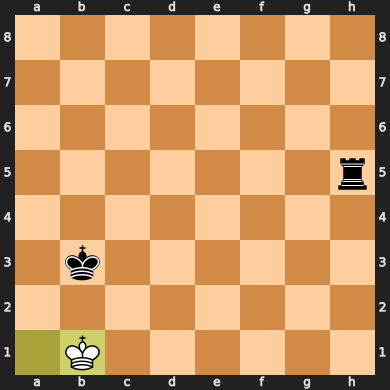

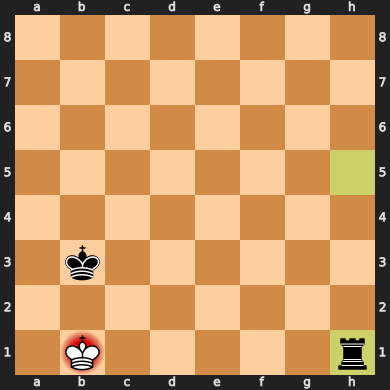

Checkmate
Saved game at games/22-12-2021_19:27:14:362360.txt


In [ ]:
x = ChessEndgame()
x.play_game([chess.Piece(chess.KING, chess.WHITE), chess.Piece(chess.KING, chess.BLACK), chess.Piece(chess.ROOK, chess.BLACK)])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>